# Standard Regression (BQML)

In [ ]:
###########################################################################
#
#  Copyright 2021 Google Inc.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
# This solution, including any related sample code or data, is made available
# on an “as is,” “as available,” and “with all faults” basis, solely for
# illustrative purposes, and without warranty or representation of any kind.
# This solution is experimental, unsupported and provided solely for your
# convenience. Your use of it is subject to your agreements with Google, as
# applicable, and may constitute a beta feature as defined under those
# agreements.  To the extent that you make any data available to Google in
# connection with your use of the solution, you represent and warrant that you
# have all necessary and appropriate rights, consents and permissions to permit
# Google to use and process that data.  By using any portion of this solution,
# you acknowledge, assume and accept all risks, known and unknown, associated
# with its usage, including with respect to your deployment of any portion of
# this solution in your systems, or usage in connection with your business,
# if at all.
###########################################################################

## 0) Dependencies

In [1]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

project_name = 'OnStar_RBA' #add proj name and dataset

In [2]:
# Google credentials authentication libraries
from google.colab import auth
auth.authenticate_user()

# BigQuery Magics
'''
BigQuery magics are used to run BigQuery SQL queries in a python environment.
These queries can also be run in the BigQuery UI
'''

from google.cloud import bigquery
from google.cloud.bigquery import magics
magics.context.project = project_name #update project name
client = bigquery.Client(project=magics.context.project)
%load_ext google.cloud.bigquery
bigquery.USE_LEGACY_SQL = False


# data processing libraries
import numpy as np
import pandas as pd


# modeling and metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, explained_variance_score
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

!pip install relativeImp
from relativeImp import relativeImp


# visutalization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from google.colab import files

## 1) Import dataset

Import the data using the bigquery magics (%% command).
Pulls all of the data from the cleaned data table and stores into a dataframe "df"

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

In [ ]:
# %%bigquery df
# SELECT *
# FROM `.RBA_demo.cleaned_data`
# ORDER BY date; #update project name

In [4]:
#update file name
#file_name = 'https://raw.githubusercontent.com/zzWIInTer/zz_onstar_rba/master/final_cleaned_data_0708.csv'
#file_name = 'https://raw.githubusercontent.com/zzWIInTer/zz_onstar_rba/master/FY2024_final_cleaned_data_0725.csv'
file_name = 'https://raw.githubusercontent.com/zzWIInTer/zz_onstar_rba/master/final_cleaned_data_08262024.csv'

df_raw = pd.read_csv(file_name)
df_raw.fillna(0, inplace=True)
df = df_raw.copy()
#df=df_raw.drop(columns=['DIV_WYG_PPl21_0p0_0d0_12'],axis=1).copy()
df.head()

,Date,A_OC_GOOGLE_SHOPPING,C_DIV_BUY_CONNECTEDl21_0p0_0d0_12,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_06,C_DIV_BUY_PREMIUMl21_0p0_0d0_0,C_DIV_BUY_SSl21_0p0_0d0_12,C_DIV_CONN_DATAl21_0p0_0d0_12,C_DIV_CONN_REMOTEl21_0p0_0d0_06,C_DIV_CONN_TRYl21_0p0_0d0_12,C_DIV_GETNOW_CONNl21_0p0_0d0_12,...,DIV_PLANPAGE_ESSl21_0p0_0d0_0,DIV_PLANPAGE_HOMEl21_0p0_0d0_0,OC_APP_Accessl21_0p0_0d0_06,OC_PAGE_PREFPLl21_0p0_0d0_12,OC_PAGE_PREMl21_0p0_0d0_12,SC_BUYNOWl21_0p0_0d0_12,SC_HOMEPAGEl21_0p0_0d0_12,SC_SHOPNOWl21_0p0_0d0_06,Is_Holiday,Is_NYE
0,10/13/2023,729,-1.342878,-0.416237,-1.087890,-0.455193,-0.702837,0.013896,-0.711413,0.298487,...,-0.366369,-0.563544,-0.703026,-1.425254,-0.631020,-0.993335,0.751124,-0.342291,0,0
1,10/14/2023,936,-1.107029,-1.767565,-0.912255,-0.750685,0.801242,-0.601467,-0.135109,0.188527,...,-0.402980,-0.806846,-0.577197,-1.261923,-0.681998,-0.993335,0.665301,0.571143,0,0
2,10/15/2023,787,-1.536485,-2.068803,-1.848976,-1.467688,-1.074814,-1.382647,0.488241,-0.986477,...,-0.476202,-1.830743,-0.697060,-1.453102,-1.210502,-0.993335,0.628519,-1.100614,0,0
3,10/16/2023,1030,-1.193272,-1.551183,-0.912255,-0.676812,-0.913085,-0.505662,-1.499420,-0.804257,...,-0.398204,-0.791640,0.733700,-0.762870,-0.190292,0.621517,0.730690,-1.204021,0,0
4,10/17/2023,950,-1.277756,-1.413292,-0.970800,-1.441615,-0.662405,-0.818871,-1.452375,-0.334570,...,0.171656,-0.446962,0.087743,-1.053063,-0.447963,-0.799553,0.129925,-1.204021,0,0


In [ ]:
df.columns

Index(['Date', 'A_OC_GOOGLE_SHOPPING', 'C_DIV_BUY_CONNECTEDl21_0p0_0d0_12',
       'C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12', 'C_DIV_BUY_PREMIUMl21_0p0_0d0_0',
       'C_DIV_BUY_SSl21_0p0_0d0_12', 'C_DIV_CONN_DATAl21_0p0_0d0_12',
       'C_DIV_CONN_REMOTEl21_0p0_0d0_12', 'C_DIV_CONN_TRYl21_0p0_0d0_06',
       'C_DIV_GETNOW_CONNl21_0p0_0d0_0', 'C_DIV_GETNOW_ESSl21_0p0_0d0_06',
       'C_DIV_GETNOW_PREMl21_0p0_0d0_06', 'C_DIV_GETNOW_SSl21_0p0_0d0_12',
       'C_PP_PKG_APP_ACCESSl21_0p0_0d0_06', 'C_PP_PKG_CONNECTEDl21_0p0_0d0_12',
       'C_PP_PKG_ESSl21_0p0_0d0_12', 'C_PP_PKG_PREMl21_0p0_0d0_06',
       'C_PP_PKG_REMOTEl21_0p0_0d0_0', 'C_PP_PKG_SCl21_0p0_0d0_06',
       'C_PP_PKG_SSl21_0p0_0d0_06', 'DIV_GMOC_SHOP_ESSl21_0p0_0d0_0',
       'DIV_GMOC_SHOP_REMOTEl21_0p0_0d0_0', 'DIV_GMOC_SHOP_SSl21_0p0_0d0_0',
       'DIV_PKG_HDStreamingl21_0p0_0d0_12', 'DIV_PKG_SS_CRASHl21_0p0_0d0_06',
       'DIV_PKG_SS_ROADSIDEl21_0p0_0d0_0', 'DIV_PLANPAGE_CONNl21_0p0_0d0_0',
       'DIV_PLANPAGE_ESSl21_0p0_0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 35 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Date                                136 non-null    object 
 1   A_OC_GOOGLE_SHOPPING                136 non-null    int64  
 2   C_DIV_BUY_CONNECTEDl21_0p0_0d0_12   136 non-null    float64
 3   C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12  136 non-null    float64
 4   C_DIV_BUY_PREMIUMl21_0p0_0d0_0      136 non-null    float64
 5   C_DIV_BUY_SSl21_0p0_0d0_12          136 non-null    float64
 6   C_DIV_CONN_DATAl21_0p0_0d0_12       136 non-null    float64
 7   C_DIV_CONN_REMOTEl21_0p0_0d0_12     136 non-null    float64
 8   C_DIV_CONN_TRYl21_0p0_0d0_06        136 non-null    float64
 9   C_DIV_GETNOW_CONNl21_0p0_0d0_0      136 non-null    float64
 10  C_DIV_GETNOW_ESSl21_0p0_0d0_06      136 non-null    float64
 11  C_DIV_GETNOW_PREMl21_0p0_0d0_06     136 non-n

Flag variables will be unique to each use case. Be sure to include the most accurate control variables and flags that represent the most relevant adjustments to your data.

In [ ]:
df.head()

,Date,A_OC_GOOGLE_SHOPPING,C_DIV_BUY_CONNECTEDl21_0p0_0d0_12,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12,C_DIV_BUY_PREMIUMl21_0p0_0d0_0,C_DIV_BUY_SSl21_0p0_0d0_12,C_DIV_CONN_DATAl21_0p0_0d0_12,C_DIV_CONN_REMOTEl21_0p0_0d0_12,C_DIV_CONN_TRYl21_0p0_0d0_06,C_DIV_GETNOW_CONNl21_0p0_0d0_0,...,DIV_PKG_SS_ROADSIDEl21_0p0_0d0_0,DIV_PLANPAGE_CONNl21_0p0_0d0_0,DIV_PLANPAGE_ESSl21_0p0_0d0_0,DIV_PLANPAGE_HOMEl21_0p0_0d0_06,OC_APP_Accessl21_0p0_0d0_06,OC_PAGE_ESSl21_0p0_0d0_06,OC_PAGE_PREFl21_0p0_0d0_06,OC_PAGE_PREMl21_0p0_0d0_0,SC_BUYNOWl21_0p0_0d0_06,SC_SHOPNOWl21_0p0_0d0_12
0,1/1/2024,354,-2.127083,-2.561218,-2.131126,-2.219054,-0.878548,-1.277200,-1.827179,-0.867772,...,0.799646,-2.235557,-1.548635,-1.797475,-2.911631,-1.073318,-2.570865,-1.364773,-0.149078,-0.422285
1,1/2/2024,1151,-1.630256,-1.736619,-1.709755,-1.697808,0.174025,-1.543707,-1.183600,-1.021791,...,1.733688,-0.641649,0.803959,-0.439094,-0.167126,3.593769,-1.396380,-0.491115,-0.911401,-1.143448
2,1/3/2024,1259,-1.385984,-0.721011,-0.656327,-1.777236,-1.474490,0.342880,-0.861810,-0.944782,...,1.349082,-0.070570,0.308007,-0.000537,-0.294314,0.827278,-1.190384,-0.402384,-0.149078,-0.422285
3,1/4/2024,1210,-0.998873,-1.075076,-1.428841,-0.799280,-0.135555,-1.003680,0.591990,-0.598239,...,1.147622,-0.377419,0.269856,-0.251329,-0.809220,0.025377,-1.098147,-0.616248,-0.911401,-0.323945
4,1/5/2024,1200,-0.644885,-2.062731,-1.709755,-0.804244,-0.336782,1.086293,-0.471065,-0.136182,...,1.257509,-0.121712,0.931126,-0.394693,-0.765847,-0.142991,-1.428523,-0.504766,3.905834,0.495558


Set KPI and date columns

In [ ]:
kpi_col = "A_OC_GOOGLE_SHOPPING" #@param {type:"string"}

In [ ]:
date_col = "Date" #@param {type:"string"}

## 2) Run the RBA Model

This model also includes a train/test split of 90/10 using the "data_split_method", "data_split_eval_fraction", and "data_split_col" parameters.

Since this data is time series, we use a sequential split with the date column as the reference point.

We suggest using a train/test split to validate model performance, but for attribution results we suggest running the model on the full dataset.

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

In [ ]:
# %%bigquery
# REATE OR REPLACE MODEL `test.model`  #update project name
# OPTIONS (model_type='linear_reg',
#         data_split_method = 'SEQ', #use these options for train/test splits
#         data_split_eval_fraction = 0.1,
#         data_split_col = 'date',
#         input_label_cols = ['y1'],
#         enable_global_explain = True)
# AS SELECT * EXCEPT(date)
#     FROM df
#     ORDER BY date; #update project name

In [ ]:

# Load your DataFrame 'df' and sort it by date
df = df.sort_values(by='Date')

# Define the fraction for the test set
test_fraction = 0.1

# Compute the index at which to split the data
split_index = int((1 - test_fraction) * len(df))

# Split the data into training and testing sets
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# Define the features (X) and target (y)
X_train = train_df.drop([kpi_col, date_col], axis=1)
y_train = train_df[kpi_col]
X_test = test_df.drop([kpi_col, date_col], axis=1)
y_test = test_df[kpi_col]

# Create and fit the model
model_train = LinearRegression()
model_train.fit(X_train, y_train)



LinearRegression()

In [ ]:
# Load your DataFrame 'df' and sort it by date
df = df.sort_values(by='Date')

# Define the features (X) and target (y)
X_all = df.drop([kpi_col, date_col], axis=1)
y_all = df[kpi_col]

# Create and fit the model
model_all = LinearRegression()
model_all.fit(X_all, y_all)


LinearRegression()

### 2.1) Print the model evaluation metrics

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

Call the model evaluation metrics from the model and save to a dataframe "evaluation_metrics".

For linear regression models The ML.EVALUATE function returns the following error metrics: mean absolute error, mean squared erorr, mean squared log error, median absolute error, r-squared, and explained variance metrics.

In [ ]:
# %%bigquery evaluation_metrics
# SELECT *
# FROM ML.EVALUATE(MODEL `.RBA_demo.RBA_model`) #update project name

In [ ]:
# evaluation_metrics

In [ ]:
# Predict using the model
y_test_pred = model_train.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
median_ae = median_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
explained_variance = explained_variance_score(y_test, y_test_pred)

# Save to a DataFrame
evaluation_metrics = pd.DataFrame({
    'Mean Absolute Error': [mae],
    'Mean Squared Error': [mse],
    'Median Absolute Error': [median_ae],
    'R-squared': [r2],
    'Explained Variance': [explained_variance]
})

evaluation_metrics


,Mean Absolute Error,Mean Squared Error,Median Absolute Error,R-squared,Explained Variance
0,112.988116,17808.455468,100.598236,-0.976816,-0.058223


In [ ]:
# Predict using the model
y_pred = model_all.predict(X_all)

# Calculate evaluation metrics
mse = mean_squared_error(y_all, y_pred)
mae = mean_absolute_error(y_all, y_pred)
median_ae = median_absolute_error(y_all, y_pred)
r2 = r2_score(y_all, y_pred)
explained_variance = explained_variance_score(y_all, y_pred)

# Save to a DataFrame
evaluation_metrics = pd.DataFrame({
    'Mean Absolute Error': [mae],
    'Mean Squared Error': [mse],
    'Median Absolute Error': [median_ae],
    'R-squared': [r2],
    'Explained Variance': [explained_variance]
})

evaluation_metrics


,Mean Absolute Error,Mean Squared Error,Median Absolute Error,R-squared,Explained Variance
0,92.455923,12813.035081,76.355881,0.785395,0.785395


In [ ]:
import statsmodels.api as sm

# Assuming X_all is your features and y_all is the target variable
X_all = sm.add_constant(X_all)  # Adding a constant to the model
model = sm.OLS(y_all, X_all).fit()  # Fit the model

# Get the summary
model_summary = model.summary()
print(model_summary)


                             OLS Regression Results                             
Dep. Variable:     A_OC_GOOGLE_SHOPPING   R-squared:                       0.785
Model:                              OLS   Adj. R-squared:                  0.716
Method:                   Least Squares   F-statistic:                     11.31
Date:                  Fri, 26 Jul 2024   Prob (F-statistic):           1.17e-21
Time:                          13:54:45   Log-Likelihood:                -836.13
No. Observations:                   136   AIC:                             1740.
Df Residuals:                       102   BIC:                             1839.
Df Model:                            33                                         
Covariance Type:              nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

### 2.2) Visualize model fit

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

Select the predicted conversions (y1) of the model and actual conversions from the data (y1) using the ML.PREDICT function

In [ ]:
# %%bigquery model_predictions
# SELECT
#   *
# FROM
#   ML.PREDICT(MODEL `.RBA_demo.RBA_model`, #update project name
#     (
#     SELECT
#         *
#     FROM
#       `.RBA_demo.cleaned_data`
#       ORDER BY date)); #update project name

Visualize the model fit by comparing predicted vs. actual data.

In [ ]:
# results = pd.DataFrame()
# results['actual'] = df[kpi_col]
# results['predicted'] = model_predictions.predicted_y1

In [ ]:
# Predict
predicted_y = model_all.predict(df.drop([kpi_col, date_col], axis=1))

# Create a DataFrame for results
results = pd.DataFrame()
results['actual'] = df[kpi_col]  # Replace kpi_col with your actual KPI column name
results['predicted'] = predicted_y

In [ ]:
# Assuming you have a DataFrame 'test_df' with features and actual values, and 'model' is your trained model


# Create the model_predictions DataFrame
model_predictions = df[[kpi_col]].copy()  # Actual values
model_predictions['predicted_y1'] = predicted_y

# Calculate residuals
model_predictions['residuals'] = model_predictions['predicted_y1'] - model_predictions[kpi_col]
#model_predictions.head()

In [ ]:
fig = px.line(results.sort_index())
fig.show()

## 3) Calculate contribution of each digital tactic on conversions

### 3.1) Relative Importance

Use the [relativeImp](https://pypi.org/project/relativeImp/) package to conduct key driver analysis and generate relative importance values by feature in the model.


The relativeImp function produces a raw relative importance and a normalized relative importance value.

- Raw relative importance sums to the r-squared of the linear model.
- Normalized relative importance is scaled to sum to 1

In [ ]:
conversions = kpi_col
df = df.drop(columns = date_col)
tactics = df[df.columns[df.columns != conversions]].columns.to_list()
relative_importance_results = relativeImp(df,
                                          outcomeName = conversions,
                                          driverNames = tactics)

In [ ]:
relative_importance_results.sort_values(by = 'rawRelaImpt', ascending = False)

,driver,rawRelaImpt,normRelaImpt
19,DIV_GMOC_SHOP_REMOTEl21_0p0_0d0_0,0.109627,13.958235
15,C_PP_PKG_REMOTEl21_0p0_0d0_0,0.099633,12.685698
5,C_DIV_CONN_REMOTEl21_0p0_0d0_12,0.050278,6.401614
27,OC_APP_Accessl21_0p0_0d0_06,0.050237,6.396415
28,OC_PAGE_ESSl21_0p0_0d0_06,0.038457,4.896501
23,DIV_PKG_SS_ROADSIDEl21_0p0_0d0_0,0.036557,4.654562
22,DIV_PKG_SS_CRASHl21_0p0_0d0_06,0.033624,4.281112
10,C_DIV_GETNOW_SSl21_0p0_0d0_12,0.032675,4.160376
9,C_DIV_GETNOW_PREMl21_0p0_0d0_06,0.031792,4.047916
13,C_PP_PKG_ESSl21_0p0_0d0_12,0.030307,3.858856


In [ ]:
round(relative_importance_results.rawRelaImpt.sum(),2) #Model's R-squared
#round(relative_importance_results.normRelaImpt.sum(),2) #Model's R-squared


0.79

## 4) Validate Linear Regression Model Assumptions

For any statistical model it is important to validate model assumptions.
With RBA, we validate the standard linear model assumptions of:

  - Linearity
  - Normality of errors
  - Absence of multicollinearity
  - Homoscedasticity
  - Absence of autocorrelation of residuals



If any of the model assumptions fail, a different model specification, as well as re-examination of the data should be considered

Incorrect model use can lead to unreliable results

### 4.1) Generate residuals

Calculate model residuals as the difference from predicted y1 values and actual y1 values


In [ ]:
model_predictions['residuals'] = model_predictions.predicted_y1 - model_predictions[kpi_col]

### 4.2) Linearity

Visually inspect linearity between target variable (y1) and predictions

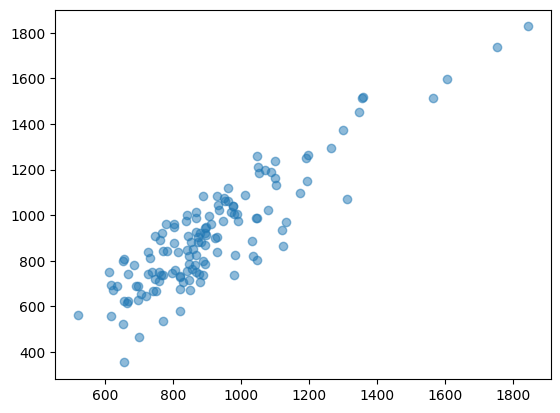

In [ ]:
plt.plot(model_predictions.predicted_y1,model_predictions[kpi_col],'o',alpha=0.5)
plt.show()

### 4.3) Normality of Errors

Visually inspect the residuals to confirm normality

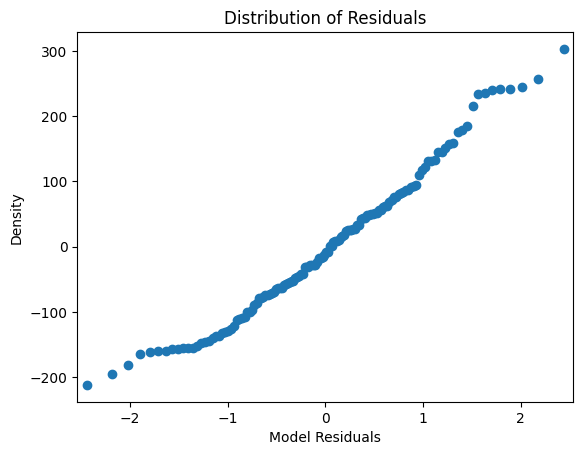

In [ ]:
fig = sm.qqplot(model_predictions.residuals)
plt.xlabel('Model Residuals'); plt.ylabel('Density'); plt.title('Distribution of Residuals');

### 4.4) Homoscedasticity


Visually inspect residuals to confirm constant variance

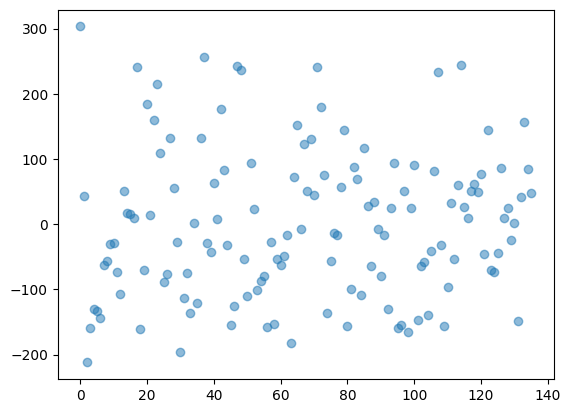

In [ ]:
plt.plot(model_predictions.residuals,'o',alpha=0.5)
plt.show()

### 4.5) Absence of Autocorrelation of the residuals

The Durbin Watson test is a statistical test for detecting autocorrelation of the model residuals

In [ ]:
dw = durbin_watson(model_predictions.residuals)
print('Durbin-Watson',round(dw,1))

Durbin-Watson 1.8


In [ ]:
if dw < 1.5:
        print('Positive autocorrelation', '\n')
elif dw > 2.5:
        print('Negative autocorrelation', '\n')
else:
        print('Little to no autocorrelation', '\n')


Little to no autocorrelation 



In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Assuming 'df' is your DataFrame with all the predictor variables
X = df.drop('A_OC_GOOGLE_SHOPPING', axis=1)  # Assuming 'y1' is your target variable

# Add a constant to the model (if it's not already included)
X = sm.add_constant(X)

# Calculating VIF for each variable
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


                               feature        VIF
0                                const   1.117263
1    C_DIV_BUY_CONNECTEDl21_0p0_0d0_12   5.908664
2   C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12   3.399430
3       C_DIV_BUY_PREMIUMl21_0p0_0d0_0   4.649410
4           C_DIV_BUY_SSl21_0p0_0d0_12   2.998830
5        C_DIV_CONN_DATAl21_0p0_0d0_12   2.227590
6      C_DIV_CONN_REMOTEl21_0p0_0d0_12   2.714213
7         C_DIV_CONN_TRYl21_0p0_0d0_06   1.689875
8       C_DIV_GETNOW_CONNl21_0p0_0d0_0   5.452635
9       C_DIV_GETNOW_ESSl21_0p0_0d0_06   2.299585
10     C_DIV_GETNOW_PREMl21_0p0_0d0_06   4.235623
11       C_DIV_GETNOW_SSl21_0p0_0d0_12   8.846567
12   C_PP_PKG_APP_ACCESSl21_0p0_0d0_06   1.944612
13    C_PP_PKG_CONNECTEDl21_0p0_0d0_12   5.796621
14          C_PP_PKG_ESSl21_0p0_0d0_12   4.861184
15         C_PP_PKG_PREMl21_0p0_0d0_06   5.539916
16        C_PP_PKG_REMOTEl21_0p0_0d0_0  15.329035
17           C_PP_PKG_SCl21_0p0_0d0_06   1.726785
18           C_PP_PKG_SSl21_0p0_0d0_06   3.661213


## 5) Export Final Results

In [ ]:
final_results_df = relative_importance_results[['driver','rawRelaImpt','normRelaImpt']]
final_results_df.to_csv('rba_final_output_Std_Reg.csv', encoding = 'utf-8-sig')
files.download('rba_final_output_Std_Reg.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>